<a href="https://colab.research.google.com/github/vicentcamison/idal_ia3/blob/main/3%20Aprendizaje%20profundo%20(II)/Sesion%203/2_GAN_2_Simple_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://medium.com/@mattiaspinelli/simple-generative-adversarial-network-gans-with-keras-1fe578e44a87


In [2]:
import os
import numpy as np

from IPython.core.debugger import Tracer

from tensorflow.keras.datasets import cifar10, mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
plt.switch_backend('agg') # allows code to run without a system DISPLAY


In [10]:
class GAN(object):
    """ Generative Adversarial Network class """
    def __init__(self, width=32, height=32, channels=3):

        self.width = width
        self.height = height
        self.channels = channels

        self.shape = (self.width, self.height, self.channels)

        self.optimizer = Adam(lr=0.0002, beta_1=0.5, decay=8e-8)

        self.G = self.__generator()
        self.G.compile(loss='binary_crossentropy', optimizer=self.optimizer)

        self.D = self.__discriminator()
        self.D.compile(loss='binary_crossentropy', optimizer=self.optimizer, metrics=['accuracy'])

        self.stacked_generator_discriminator = self.__stacked_generator_discriminator()

        self.stacked_generator_discriminator.compile(loss='binary_crossentropy', optimizer=self.optimizer)


    def __generator(self):
        """ Declare generator """

        model = Sequential()
        model.add(Dense(256, input_shape=(100,)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(self.width  * self.height * self.channels, activation='tanh'))
        model.add(Reshape((self.width, self.height, self.channels)))

        return model

    def __discriminator(self):
        """ Declare discriminator """

        model = Sequential()
        model.add(Flatten(input_shape=self.shape))
        model.add(Dense((self.width * self.height * self.channels), input_shape=self.shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(np.int64((self.width * self.height * self.channels)/2)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        return model

    def __stacked_generator_discriminator(self):

        self.D.trainable = False

        model = Sequential()
        model.add(self.G)
        model.add(self.D)

        return model

    def train(self, X_train, epochs=20000, batch = 32, save_interval = 100):

        DD_loss = np.zeros((epochs,))
        GG_loss = np.zeros((epochs,))
        for cnt in range(epochs):

            ## train discriminator
            random_index = np.random.randint(0, len(X_train) - np.int64(batch/2))
            legit_images = X_train[random_index : random_index + np.int64(batch/2)].reshape(np.int64(batch/2), self.width, self.height, self.channels)

            gen_noise = np.random.normal(0, 1, (np.int64(batch/2), 100))
            syntetic_images = self.G.predict(gen_noise)

            x_combined_batch = np.concatenate((legit_images, syntetic_images))
            y_combined_batch = np.concatenate((np.ones((np.int64(batch/2), 1)), np.zeros((np.int64(batch/2), 1))))

            d_loss = self.D.train_on_batch(x_combined_batch, y_combined_batch)


            # train generator

            noise = np.random.normal(0, 1, (batch, 100))
            y_mislabled = np.ones((batch, 1))

            g_loss = self.stacked_generator_discriminator.train_on_batch(noise, y_mislabled)

            print ('epoch: %d, [Discriminator :: d_loss: %f], [ Generator :: loss: %f]' % (cnt, d_loss[0], g_loss))

            DD_loss[cnt] = d_loss[0]
            GG_loss[cnt] = g_loss
            if cnt % save_interval == 0:
                self.plot_images(save2file=True, step=cnt)
        return  DD_loss, GG_loss

    def plot_images(self, save2file=False, samples=16, step=0):
        ''' Plot and generated images '''
        if not os.path.exists("./images"):
            os.makedirs("./images")
        filename = "./images/mnist_%d.png" % step
        noise = np.random.normal(0, 1, (samples, 100))

        images = self.G.predict(noise)

        plt.figure(figsize=(10, 10))

        for i in range(images.shape[0]):
            plt.subplot(4, 4, i+1)
            image = images[i, :, :, :]
            image = np.reshape(image, [self.height, self.width, self.channels])
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.tight_layout()

        if save2file:
            plt.savefig(filename)
            plt.close('all')
        else:
            plt.show()





In [9]:
X_train.shape

(50000, 32, 32, 3)

In [12]:

(X_train, _), (_, _) = cifar10.load_data()

# Rescale -1 to 1
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
#X_train = np.expand_dims(X_train, axis=3) #esto era para el MNIST. No hay que añadir la dimensión de canales porque ya la tenemos añadida

gan = GAN()
DD, GG = gan.train(X_train, epochs=600)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 3072)              9440256   
_________________________________________________________________
leaky_re_lu_23 (LeakyReLU)   (None, 3072)              0         
_________________________________________________________________
dense_33 (Dense)             (None, 1536)              4720128   
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 1536)              0         
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 1537      
Total params: 14,161,921
Trainable params: 14,161,921
Non-trainable params: 0
_________________________________________

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch: 0, [Discriminator :: d_loss: 0.766087], [ Generator :: loss: 0.155428]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 1, [Discriminator :: d_loss: 0.408389], [ Generator :: loss: 0.090940]
epoch: 2, [Discriminator :: d_loss: 0.412007], [ Generator :: loss: 0.196376]
epoch: 3, [Discriminator :: d_loss: 0.484096], [ Generator :: loss: 0.442294]
epoch: 4, [Discriminator :: d_loss: 0.430096], [ Generator :: loss: 1.065920]
epoch: 5, [Discriminator :: d_loss: 0.320575], [ Generator :: loss: 1.543028]
epoch: 6, [Discriminator :: d_loss: 0.252865], [ Generator :: loss: 2.219363]
epoch: 7, [Discriminator :: d_loss: 0.204903], [ Generator :: loss: 1.879355]
epoch: 8, [Discriminator :: d_loss: 0.309050], [ Generator :: loss: 0.806517]
epoch: 9, [Discriminator :: d_loss: 0.271625], [ Generator :: loss: 1.204936]
epoch: 10, [Discriminator :: d_loss: 0.402753], [ Generator :: loss: 1.097067]
epoch: 11, [Discriminator :: d_loss: 0.312778], [ Generator :: loss: 2.451045]
epoch: 12, [Discriminator :: d_loss: 0.415134], [ Generator :: loss: 2.250335]
epoch: 13, [Discriminator :: d_loss: 0.193117], [ Generator :

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch: 101, [Discriminator :: d_loss: 0.288318], [ Generator :: loss: 1.448477]
epoch: 102, [Discriminator :: d_loss: 0.379682], [ Generator :: loss: 1.812320]
epoch: 103, [Discriminator :: d_loss: 0.402042], [ Generator :: loss: 2.218492]
epoch: 104, [Discriminator :: d_loss: 0.405866], [ Generator :: loss: 2.130758]
epoch: 105, [Discriminator :: d_loss: 0.335362], [ Generator :: loss: 2.225173]
epoch: 106, [Discriminator :: d_loss: 0.398627], [ Generator :: loss: 1.974853]
epoch: 107, [Discriminator :: d_loss: 0.383421], [ Generator :: loss: 1.409993]
epoch: 108, [Discriminator :: d_loss: 0.517465], [ Generator :: loss: 1.406884]
epoch: 109, [Discriminator :: d_loss: 0.387435], [ Generator :: loss: 1.822825]
epoch: 110, [Discriminator :: d_loss: 0.359503], [ Generator :: loss: 2.445347]
epoch: 111, [Discriminator :: d_loss: 0.552093], [ Generator :: loss: 1.810334]
epoch: 112, [Discriminator :: d_loss: 0.649775], [ Generator :: loss: 1.836311]
epoch: 113, [Discriminator :: d_loss: 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch: 201, [Discriminator :: d_loss: 0.720374], [ Generator :: loss: 1.658775]
epoch: 202, [Discriminator :: d_loss: 0.591766], [ Generator :: loss: 1.196764]
epoch: 203, [Discriminator :: d_loss: 0.521120], [ Generator :: loss: 0.855772]
epoch: 204, [Discriminator :: d_loss: 0.447733], [ Generator :: loss: 1.137610]
epoch: 205, [Discriminator :: d_loss: 0.498701], [ Generator :: loss: 1.798460]
epoch: 206, [Discriminator :: d_loss: 0.837911], [ Generator :: loss: 1.891806]
epoch: 207, [Discriminator :: d_loss: 0.603569], [ Generator :: loss: 1.597138]
epoch: 208, [Discriminator :: d_loss: 0.549135], [ Generator :: loss: 1.378301]
epoch: 209, [Discriminator :: d_loss: 0.436645], [ Generator :: loss: 1.468585]
epoch: 210, [Discriminator :: d_loss: 0.435969], [ Generator :: loss: 1.287141]
epoch: 211, [Discriminator :: d_loss: 0.781286], [ Generator :: loss: 1.532291]
epoch: 212, [Discriminator :: d_loss: 0.503821], [ Generator :: loss: 1.480395]
epoch: 213, [Discriminator :: d_loss: 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch: 301, [Discriminator :: d_loss: 0.760439], [ Generator :: loss: 1.046846]
epoch: 302, [Discriminator :: d_loss: 0.697209], [ Generator :: loss: 1.403305]
epoch: 303, [Discriminator :: d_loss: 0.502637], [ Generator :: loss: 1.849559]
epoch: 304, [Discriminator :: d_loss: 0.511957], [ Generator :: loss: 1.723667]
epoch: 305, [Discriminator :: d_loss: 0.539840], [ Generator :: loss: 1.314064]
epoch: 306, [Discriminator :: d_loss: 0.598821], [ Generator :: loss: 1.387405]
epoch: 307, [Discriminator :: d_loss: 1.001977], [ Generator :: loss: 0.752046]
epoch: 308, [Discriminator :: d_loss: 0.781291], [ Generator :: loss: 0.911435]
epoch: 309, [Discriminator :: d_loss: 0.632967], [ Generator :: loss: 1.262000]
epoch: 310, [Discriminator :: d_loss: 0.671809], [ Generator :: loss: 1.150934]
epoch: 311, [Discriminator :: d_loss: 0.459941], [ Generator :: loss: 1.191429]
epoch: 312, [Discriminator :: d_loss: 0.488485], [ Generator :: loss: 1.286605]
epoch: 313, [Discriminator :: d_loss: 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch: 401, [Discriminator :: d_loss: 0.691410], [ Generator :: loss: 1.034062]
epoch: 402, [Discriminator :: d_loss: 0.605189], [ Generator :: loss: 1.257973]
epoch: 403, [Discriminator :: d_loss: 0.641792], [ Generator :: loss: 1.170242]
epoch: 404, [Discriminator :: d_loss: 0.597218], [ Generator :: loss: 1.000577]
epoch: 405, [Discriminator :: d_loss: 0.785458], [ Generator :: loss: 1.453376]
epoch: 406, [Discriminator :: d_loss: 0.531682], [ Generator :: loss: 1.655370]
epoch: 407, [Discriminator :: d_loss: 0.627248], [ Generator :: loss: 1.229463]
epoch: 408, [Discriminator :: d_loss: 0.614513], [ Generator :: loss: 0.987059]
epoch: 409, [Discriminator :: d_loss: 0.636889], [ Generator :: loss: 1.173674]
epoch: 410, [Discriminator :: d_loss: 0.685730], [ Generator :: loss: 1.497874]
epoch: 411, [Discriminator :: d_loss: 0.639778], [ Generator :: loss: 1.443015]
epoch: 412, [Discriminator :: d_loss: 0.651198], [ Generator :: loss: 1.313576]
epoch: 413, [Discriminator :: d_loss: 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch: 501, [Discriminator :: d_loss: 0.680274], [ Generator :: loss: 1.125624]
epoch: 502, [Discriminator :: d_loss: 0.603761], [ Generator :: loss: 1.065525]
epoch: 503, [Discriminator :: d_loss: 0.712894], [ Generator :: loss: 0.979238]
epoch: 504, [Discriminator :: d_loss: 0.617781], [ Generator :: loss: 0.821556]
epoch: 505, [Discriminator :: d_loss: 0.554876], [ Generator :: loss: 1.035411]
epoch: 506, [Discriminator :: d_loss: 0.750531], [ Generator :: loss: 1.259293]
epoch: 507, [Discriminator :: d_loss: 0.463502], [ Generator :: loss: 1.381533]
epoch: 508, [Discriminator :: d_loss: 0.722258], [ Generator :: loss: 1.349189]
epoch: 509, [Discriminator :: d_loss: 0.386796], [ Generator :: loss: 1.705025]
epoch: 510, [Discriminator :: d_loss: 0.645520], [ Generator :: loss: 1.310883]
epoch: 511, [Discriminator :: d_loss: 0.569439], [ Generator :: loss: 1.233949]
epoch: 512, [Discriminator :: d_loss: 0.682640], [ Generator :: loss: 1.508043]
epoch: 513, [Discriminator :: d_loss: 0.

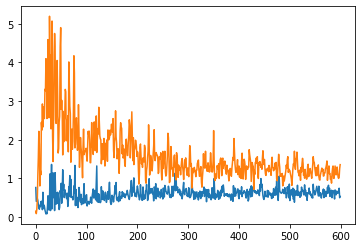

In [13]:
% matplotlib inline 
plt.figure
plt.plot(DD)
plt.plot(GG)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

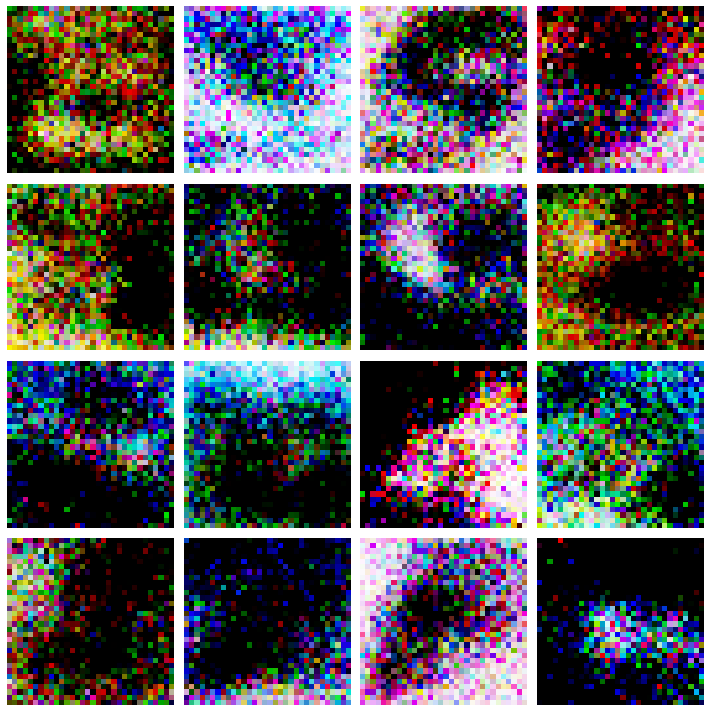

In [14]:
% matplotlib inline 
gan.plot_images()

In [15]:

DD_2000, GG_2000 = gan.train(X_train, epochs=2000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch: 0, [Discriminator :: d_loss: 0.839229], [ Generator :: loss: 1.183281]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 1, [Discriminator :: d_loss: 0.547016], [ Generator :: loss: 1.031056]
epoch: 2, [Discriminator :: d_loss: 0.663131], [ Generator :: loss: 0.984738]
epoch: 3, [Discriminator :: d_loss: 0.582349], [ Generator :: loss: 0.938920]
epoch: 4, [Discriminator :: d_loss: 0.645207], [ Generator :: loss: 1.019363]
epoch: 5, [Discriminator :: d_loss: 0.690468], [ Generator :: loss: 1.138351]
epoch: 6, [Discriminator :: d_loss: 0.631852], [ Generator :: loss: 0.992165]
epoch: 7, [Discriminator :: d_loss: 0.637550], [ Generator :: loss: 1.021587]
epoch: 8, [Discriminator :: d_loss: 0.672358], [ Generator :: loss: 1.077518]
epoch: 9, [Discriminator :: d_loss: 0.639774], [ Generator :: loss: 1.088514]
epoch: 10, [Discriminator :: d_loss: 0.636587], [ Generator :: loss: 1.253059]
epoch: 11, [Discriminator :: d_loss: 0.689640], [ Generator :: loss: 1.060656]
epoch: 12, [Discriminator :: d_loss: 0.585373], [ Generator :: loss: 1.203332]
epoch: 13, [Discriminator :: d_loss: 0.715108], [ Generator :

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch: 101, [Discriminator :: d_loss: 0.625283], [ Generator :: loss: 1.098534]
epoch: 102, [Discriminator :: d_loss: 0.631503], [ Generator :: loss: 0.975438]
epoch: 103, [Discriminator :: d_loss: 0.577025], [ Generator :: loss: 0.921795]
epoch: 104, [Discriminator :: d_loss: 0.542035], [ Generator :: loss: 0.925837]
epoch: 105, [Discriminator :: d_loss: 0.765030], [ Generator :: loss: 0.879870]
epoch: 106, [Discriminator :: d_loss: 0.608071], [ Generator :: loss: 0.973576]
epoch: 107, [Discriminator :: d_loss: 0.708514], [ Generator :: loss: 1.039208]
epoch: 108, [Discriminator :: d_loss: 0.654227], [ Generator :: loss: 1.001002]
epoch: 109, [Discriminator :: d_loss: 0.702716], [ Generator :: loss: 1.020254]
epoch: 110, [Discriminator :: d_loss: 0.596252], [ Generator :: loss: 1.045915]
epoch: 111, [Discriminator :: d_loss: 0.686260], [ Generator :: loss: 0.970840]
epoch: 112, [Discriminator :: d_loss: 0.591594], [ Generator :: loss: 1.021456]
epoch: 113, [Discriminator :: d_loss: 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch: 201, [Discriminator :: d_loss: 0.654146], [ Generator :: loss: 0.820793]
epoch: 202, [Discriminator :: d_loss: 0.682157], [ Generator :: loss: 1.013710]
epoch: 203, [Discriminator :: d_loss: 0.693020], [ Generator :: loss: 1.066510]
epoch: 204, [Discriminator :: d_loss: 0.645550], [ Generator :: loss: 1.111492]
epoch: 205, [Discriminator :: d_loss: 0.647516], [ Generator :: loss: 1.234382]
epoch: 206, [Discriminator :: d_loss: 0.607835], [ Generator :: loss: 1.087584]
epoch: 207, [Discriminator :: d_loss: 0.659505], [ Generator :: loss: 0.965444]
epoch: 208, [Discriminator :: d_loss: 0.700289], [ Generator :: loss: 1.090297]
epoch: 209, [Discriminator :: d_loss: 0.722031], [ Generator :: loss: 0.950727]
epoch: 210, [Discriminator :: d_loss: 0.547275], [ Generator :: loss: 1.009268]
epoch: 211, [Discriminator :: d_loss: 0.685115], [ Generator :: loss: 1.020074]
epoch: 212, [Discriminator :: d_loss: 0.635225], [ Generator :: loss: 1.183353]
epoch: 213, [Discriminator :: d_loss: 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch: 301, [Discriminator :: d_loss: 0.618242], [ Generator :: loss: 0.894795]
epoch: 302, [Discriminator :: d_loss: 0.745885], [ Generator :: loss: 0.795892]
epoch: 303, [Discriminator :: d_loss: 0.781802], [ Generator :: loss: 0.916740]
epoch: 304, [Discriminator :: d_loss: 0.668377], [ Generator :: loss: 0.950567]
epoch: 305, [Discriminator :: d_loss: 0.561877], [ Generator :: loss: 1.072397]
epoch: 306, [Discriminator :: d_loss: 0.747019], [ Generator :: loss: 0.989066]
epoch: 307, [Discriminator :: d_loss: 0.589326], [ Generator :: loss: 0.881450]
epoch: 308, [Discriminator :: d_loss: 0.658451], [ Generator :: loss: 0.939206]
epoch: 309, [Discriminator :: d_loss: 0.643332], [ Generator :: loss: 0.897538]
epoch: 310, [Discriminator :: d_loss: 0.572498], [ Generator :: loss: 0.860316]
epoch: 311, [Discriminator :: d_loss: 0.766336], [ Generator :: loss: 1.064716]
epoch: 312, [Discriminator :: d_loss: 0.700409], [ Generator :: loss: 0.970073]
epoch: 313, [Discriminator :: d_loss: 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch: 400, [Discriminator :: d_loss: 0.838503], [ Generator :: loss: 0.872897]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 401, [Discriminator :: d_loss: 0.574894], [ Generator :: loss: 1.025600]
epoch: 402, [Discriminator :: d_loss: 0.642353], [ Generator :: loss: 0.966242]
epoch: 403, [Discriminator :: d_loss: 0.681955], [ Generator :: loss: 0.933012]
epoch: 404, [Discriminator :: d_loss: 0.763164], [ Generator :: loss: 0.924994]
epoch: 405, [Discriminator :: d_loss: 0.704405], [ Generator :: loss: 0.993694]
epoch: 406, [Discriminator :: d_loss: 0.566673], [ Generator :: loss: 1.038301]
epoch: 407, [Discriminator :: d_loss: 0.794735], [ Generator :: loss: 1.038296]
epoch: 408, [Discriminator :: d_loss: 0.695097], [ Generator :: loss: 0.896966]
epoch: 409, [Discriminator :: d_loss: 0.646338], [ Generator :: loss: 0.816528]
epoch: 410, [Discriminator :: d_loss: 0.656430], [ Generator :: loss: 0.838018]
epoch: 411, [Discriminator :: d_loss: 0.566193], [ Generator :: loss: 0.978597]
epoch: 412, [Discriminator :: d_loss: 0.893266], [ Generator :: loss: 0.871252]
epoch: 413, [Discriminator :: d_loss: 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch: 501, [Discriminator :: d_loss: 0.667256], [ Generator :: loss: 0.990174]
epoch: 502, [Discriminator :: d_loss: 0.767421], [ Generator :: loss: 0.713165]
epoch: 503, [Discriminator :: d_loss: 0.812111], [ Generator :: loss: 0.701875]
epoch: 504, [Discriminator :: d_loss: 0.690466], [ Generator :: loss: 0.804261]
epoch: 505, [Discriminator :: d_loss: 0.597477], [ Generator :: loss: 0.842767]
epoch: 506, [Discriminator :: d_loss: 0.699380], [ Generator :: loss: 0.860881]
epoch: 507, [Discriminator :: d_loss: 0.716457], [ Generator :: loss: 1.089739]
epoch: 508, [Discriminator :: d_loss: 0.564113], [ Generator :: loss: 1.021367]
epoch: 509, [Discriminator :: d_loss: 0.707678], [ Generator :: loss: 0.897032]
epoch: 510, [Discriminator :: d_loss: 0.609744], [ Generator :: loss: 0.843548]
epoch: 511, [Discriminator :: d_loss: 0.618934], [ Generator :: loss: 0.814832]
epoch: 512, [Discriminator :: d_loss: 0.584046], [ Generator :: loss: 0.791678]
epoch: 513, [Discriminator :: d_loss: 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch: 601, [Discriminator :: d_loss: 0.651228], [ Generator :: loss: 1.058542]
epoch: 602, [Discriminator :: d_loss: 0.698562], [ Generator :: loss: 0.958830]
epoch: 603, [Discriminator :: d_loss: 0.634263], [ Generator :: loss: 0.896059]
epoch: 604, [Discriminator :: d_loss: 0.606039], [ Generator :: loss: 0.923507]
epoch: 605, [Discriminator :: d_loss: 0.593490], [ Generator :: loss: 0.932771]
epoch: 606, [Discriminator :: d_loss: 0.591200], [ Generator :: loss: 0.939622]
epoch: 607, [Discriminator :: d_loss: 0.670976], [ Generator :: loss: 0.959067]
epoch: 608, [Discriminator :: d_loss: 0.759595], [ Generator :: loss: 0.994186]
epoch: 609, [Discriminator :: d_loss: 0.613890], [ Generator :: loss: 1.103307]
epoch: 610, [Discriminator :: d_loss: 0.711383], [ Generator :: loss: 1.094301]
epoch: 611, [Discriminator :: d_loss: 0.732832], [ Generator :: loss: 0.994965]
epoch: 612, [Discriminator :: d_loss: 0.570504], [ Generator :: loss: 0.892947]
epoch: 613, [Discriminator :: d_loss: 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch: 701, [Discriminator :: d_loss: 0.570578], [ Generator :: loss: 1.004207]
epoch: 702, [Discriminator :: d_loss: 0.795680], [ Generator :: loss: 1.046969]
epoch: 703, [Discriminator :: d_loss: 0.619992], [ Generator :: loss: 1.011716]
epoch: 704, [Discriminator :: d_loss: 0.624376], [ Generator :: loss: 1.036206]
epoch: 705, [Discriminator :: d_loss: 0.662239], [ Generator :: loss: 0.921061]
epoch: 706, [Discriminator :: d_loss: 0.699209], [ Generator :: loss: 0.921624]
epoch: 707, [Discriminator :: d_loss: 0.791380], [ Generator :: loss: 0.873147]
epoch: 708, [Discriminator :: d_loss: 0.609750], [ Generator :: loss: 0.799231]
epoch: 709, [Discriminator :: d_loss: 0.584972], [ Generator :: loss: 0.849897]
epoch: 710, [Discriminator :: d_loss: 0.734598], [ Generator :: loss: 0.888915]
epoch: 711, [Discriminator :: d_loss: 0.691789], [ Generator :: loss: 0.975112]
epoch: 712, [Discriminator :: d_loss: 0.828185], [ Generator :: loss: 0.925168]
epoch: 713, [Discriminator :: d_loss: 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch: 801, [Discriminator :: d_loss: 0.757307], [ Generator :: loss: 0.859589]
epoch: 802, [Discriminator :: d_loss: 0.646277], [ Generator :: loss: 0.860887]
epoch: 803, [Discriminator :: d_loss: 0.639925], [ Generator :: loss: 0.924357]
epoch: 804, [Discriminator :: d_loss: 0.723473], [ Generator :: loss: 0.919216]
epoch: 805, [Discriminator :: d_loss: 0.625811], [ Generator :: loss: 0.935715]
epoch: 806, [Discriminator :: d_loss: 0.675167], [ Generator :: loss: 0.760516]
epoch: 807, [Discriminator :: d_loss: 0.637601], [ Generator :: loss: 0.804901]
epoch: 808, [Discriminator :: d_loss: 0.819301], [ Generator :: loss: 0.828289]
epoch: 809, [Discriminator :: d_loss: 0.632986], [ Generator :: loss: 0.883946]
epoch: 810, [Discriminator :: d_loss: 0.713128], [ Generator :: loss: 0.890129]
epoch: 811, [Discriminator :: d_loss: 0.644495], [ Generator :: loss: 0.852647]
epoch: 812, [Discriminator :: d_loss: 0.630229], [ Generator :: loss: 0.771079]
epoch: 813, [Discriminator :: d_loss: 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch: 901, [Discriminator :: d_loss: 0.553905], [ Generator :: loss: 0.827335]
epoch: 902, [Discriminator :: d_loss: 0.658578], [ Generator :: loss: 0.808007]
epoch: 903, [Discriminator :: d_loss: 0.721251], [ Generator :: loss: 0.761171]
epoch: 904, [Discriminator :: d_loss: 0.738578], [ Generator :: loss: 0.789892]
epoch: 905, [Discriminator :: d_loss: 0.530487], [ Generator :: loss: 0.762542]
epoch: 906, [Discriminator :: d_loss: 0.689088], [ Generator :: loss: 0.840601]
epoch: 907, [Discriminator :: d_loss: 0.611099], [ Generator :: loss: 0.874266]
epoch: 908, [Discriminator :: d_loss: 0.823483], [ Generator :: loss: 0.796949]
epoch: 909, [Discriminator :: d_loss: 0.597600], [ Generator :: loss: 0.849400]
epoch: 910, [Discriminator :: d_loss: 0.691769], [ Generator :: loss: 0.892419]
epoch: 911, [Discriminator :: d_loss: 0.636058], [ Generator :: loss: 0.906500]
epoch: 912, [Discriminator :: d_loss: 0.606976], [ Generator :: loss: 0.924203]
epoch: 913, [Discriminator :: d_loss: 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch: 1000, [Discriminator :: d_loss: 0.628823], [ Generator :: loss: 0.825505]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 1001, [Discriminator :: d_loss: 0.579910], [ Generator :: loss: 0.711810]
epoch: 1002, [Discriminator :: d_loss: 0.739253], [ Generator :: loss: 0.833002]
epoch: 1003, [Discriminator :: d_loss: 0.689665], [ Generator :: loss: 0.766817]
epoch: 1004, [Discriminator :: d_loss: 0.767891], [ Generator :: loss: 0.735115]
epoch: 1005, [Discriminator :: d_loss: 0.647600], [ Generator :: loss: 0.780359]
epoch: 1006, [Discriminator :: d_loss: 0.607999], [ Generator :: loss: 0.785470]
epoch: 1007, [Discriminator :: d_loss: 0.731291], [ Generator :: loss: 0.831566]
epoch: 1008, [Discriminator :: d_loss: 0.745972], [ Generator :: loss: 0.911520]
epoch: 1009, [Discriminator :: d_loss: 0.679894], [ Generator :: loss: 1.041501]
epoch: 1010, [Discriminator :: d_loss: 1.010795], [ Generator :: loss: 0.825266]
epoch: 1011, [Discriminator :: d_loss: 0.791738], [ Generator :: loss: 0.785552]
epoch: 1012, [Discriminator :: d_loss: 0.683294], [ Generator :: loss: 0.725434]
epoch: 1013, [Discriminator 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch: 1101, [Discriminator :: d_loss: 0.631290], [ Generator :: loss: 0.801565]
epoch: 1102, [Discriminator :: d_loss: 0.703384], [ Generator :: loss: 0.745454]
epoch: 1103, [Discriminator :: d_loss: 0.668156], [ Generator :: loss: 0.762811]
epoch: 1104, [Discriminator :: d_loss: 0.674588], [ Generator :: loss: 0.815071]
epoch: 1105, [Discriminator :: d_loss: 0.691664], [ Generator :: loss: 0.817842]
epoch: 1106, [Discriminator :: d_loss: 0.655784], [ Generator :: loss: 0.791239]
epoch: 1107, [Discriminator :: d_loss: 0.616948], [ Generator :: loss: 0.772690]
epoch: 1108, [Discriminator :: d_loss: 0.711793], [ Generator :: loss: 0.816262]
epoch: 1109, [Discriminator :: d_loss: 0.660143], [ Generator :: loss: 0.799325]
epoch: 1110, [Discriminator :: d_loss: 0.633069], [ Generator :: loss: 0.899214]
epoch: 1111, [Discriminator :: d_loss: 0.600812], [ Generator :: loss: 0.885744]
epoch: 1112, [Discriminator :: d_loss: 0.705183], [ Generator :: loss: 0.786483]
epoch: 1113, [Discriminator 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch: 1200, [Discriminator :: d_loss: 0.705470], [ Generator :: loss: 0.716220]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 1201, [Discriminator :: d_loss: 0.607501], [ Generator :: loss: 0.717270]
epoch: 1202, [Discriminator :: d_loss: 0.681008], [ Generator :: loss: 0.850822]
epoch: 1203, [Discriminator :: d_loss: 0.613830], [ Generator :: loss: 0.842024]
epoch: 1204, [Discriminator :: d_loss: 0.717219], [ Generator :: loss: 0.824058]
epoch: 1205, [Discriminator :: d_loss: 0.700773], [ Generator :: loss: 0.806603]
epoch: 1206, [Discriminator :: d_loss: 0.633961], [ Generator :: loss: 0.848501]
epoch: 1207, [Discriminator :: d_loss: 0.580409], [ Generator :: loss: 0.908699]
epoch: 1208, [Discriminator :: d_loss: 0.714108], [ Generator :: loss: 0.848407]
epoch: 1209, [Discriminator :: d_loss: 0.698871], [ Generator :: loss: 0.816918]
epoch: 1210, [Discriminator :: d_loss: 0.598141], [ Generator :: loss: 0.765620]
epoch: 1211, [Discriminator :: d_loss: 0.636963], [ Generator :: loss: 0.810678]
epoch: 1212, [Discriminator :: d_loss: 0.660045], [ Generator :: loss: 0.758946]
epoch: 1213, [Discriminator 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch: 1301, [Discriminator :: d_loss: 0.576274], [ Generator :: loss: 0.682251]
epoch: 1302, [Discriminator :: d_loss: 0.691752], [ Generator :: loss: 0.714265]
epoch: 1303, [Discriminator :: d_loss: 0.618844], [ Generator :: loss: 0.712943]
epoch: 1304, [Discriminator :: d_loss: 0.705569], [ Generator :: loss: 0.745922]
epoch: 1305, [Discriminator :: d_loss: 0.677419], [ Generator :: loss: 0.721764]
epoch: 1306, [Discriminator :: d_loss: 0.642984], [ Generator :: loss: 0.727741]
epoch: 1307, [Discriminator :: d_loss: 0.582420], [ Generator :: loss: 0.774009]
epoch: 1308, [Discriminator :: d_loss: 0.635180], [ Generator :: loss: 0.789077]
epoch: 1309, [Discriminator :: d_loss: 0.627449], [ Generator :: loss: 0.847270]
epoch: 1310, [Discriminator :: d_loss: 0.772518], [ Generator :: loss: 0.777808]
epoch: 1311, [Discriminator :: d_loss: 0.659212], [ Generator :: loss: 0.819475]
epoch: 1312, [Discriminator :: d_loss: 0.689669], [ Generator :: loss: 0.834644]
epoch: 1313, [Discriminator 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 1397, [Discriminator :: d_loss: 0.669634], [ Generator :: loss: 0.752540]
epoch: 1398, [Discriminator :: d_loss: 0.620517], [ Generator :: loss: 0.787649]
epoch: 1399, [Discriminator :: d_loss: 0.702771], [ Generator :: loss: 0.783766]
epoch: 1400, [Discriminator :: d_loss: 0.671597], [ Generator :: loss: 0.750655]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch: 1401, [Discriminator :: d_loss: 0.692364], [ Generator :: loss: 0.754640]
epoch: 1402, [Discriminator :: d_loss: 0.671927], [ Generator :: loss: 0.756018]
epoch: 1403, [Discriminator :: d_loss: 0.751661], [ Generator :: loss: 0.769418]
epoch: 1404, [Discriminator :: d_loss: 0.599389], [ Generator :: loss: 0.722308]
epoch: 1405, [Discriminator :: d_loss: 0.695661], [ Generator :: loss: 0.724381]
epoch: 1406, [Discriminator :: d_loss: 0.663137], [ Generator :: loss: 0.721473]
epoch: 1407, [Discriminator :: d_loss: 0.698795], [ Generator :: loss: 0.800053]
epoch: 1408, [Discriminator :: d_loss: 0.634808], [ Generator :: loss: 0.848671]
epoch: 1409, [Discriminator :: d_loss: 0.692761], [ Generator :: loss: 0.801451]
epoch: 1410, [Discriminator :: d_loss: 0.633060], [ Generator :: loss: 0.820895]
epoch: 1411, [Discriminator :: d_loss: 0.753395], [ Generator :: loss: 0.799506]
epoch: 1412, [Discriminator :: d_loss: 0.680316], [ Generator :: loss: 0.793721]
epoch: 1413, [Discriminator 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch: 1501, [Discriminator :: d_loss: 0.698035], [ Generator :: loss: 0.824437]
epoch: 1502, [Discriminator :: d_loss: 0.672833], [ Generator :: loss: 0.734180]
epoch: 1503, [Discriminator :: d_loss: 0.701838], [ Generator :: loss: 0.817115]
epoch: 1504, [Discriminator :: d_loss: 0.710500], [ Generator :: loss: 0.814802]
epoch: 1505, [Discriminator :: d_loss: 0.682680], [ Generator :: loss: 0.859826]
epoch: 1506, [Discriminator :: d_loss: 0.668501], [ Generator :: loss: 0.799480]
epoch: 1507, [Discriminator :: d_loss: 0.726972], [ Generator :: loss: 0.681812]
epoch: 1508, [Discriminator :: d_loss: 0.697120], [ Generator :: loss: 0.647205]
epoch: 1509, [Discriminator :: d_loss: 0.647951], [ Generator :: loss: 0.639168]
epoch: 1510, [Discriminator :: d_loss: 0.614285], [ Generator :: loss: 0.713984]
epoch: 1511, [Discriminator :: d_loss: 0.827828], [ Generator :: loss: 0.708582]
epoch: 1512, [Discriminator :: d_loss: 0.740752], [ Generator :: loss: 0.850172]
epoch: 1513, [Discriminator 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch: 1601, [Discriminator :: d_loss: 0.591139], [ Generator :: loss: 0.727985]
epoch: 1602, [Discriminator :: d_loss: 0.660713], [ Generator :: loss: 0.780341]
epoch: 1603, [Discriminator :: d_loss: 0.676218], [ Generator :: loss: 0.795532]
epoch: 1604, [Discriminator :: d_loss: 0.725144], [ Generator :: loss: 0.825995]
epoch: 1605, [Discriminator :: d_loss: 0.584489], [ Generator :: loss: 0.832519]
epoch: 1606, [Discriminator :: d_loss: 0.631437], [ Generator :: loss: 0.856392]
epoch: 1607, [Discriminator :: d_loss: 0.724927], [ Generator :: loss: 0.800918]
epoch: 1608, [Discriminator :: d_loss: 0.718934], [ Generator :: loss: 0.762221]
epoch: 1609, [Discriminator :: d_loss: 0.663007], [ Generator :: loss: 0.714189]
epoch: 1610, [Discriminator :: d_loss: 0.673906], [ Generator :: loss: 0.685078]
epoch: 1611, [Discriminator :: d_loss: 0.775186], [ Generator :: loss: 0.728468]
epoch: 1612, [Discriminator :: d_loss: 0.753441], [ Generator :: loss: 0.732458]
epoch: 1613, [Discriminator 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch: 1701, [Discriminator :: d_loss: 0.646546], [ Generator :: loss: 0.708068]
epoch: 1702, [Discriminator :: d_loss: 0.744501], [ Generator :: loss: 0.731940]
epoch: 1703, [Discriminator :: d_loss: 0.694584], [ Generator :: loss: 0.695809]
epoch: 1704, [Discriminator :: d_loss: 0.697251], [ Generator :: loss: 0.701518]
epoch: 1705, [Discriminator :: d_loss: 0.720115], [ Generator :: loss: 0.724232]
epoch: 1706, [Discriminator :: d_loss: 0.666995], [ Generator :: loss: 0.772699]
epoch: 1707, [Discriminator :: d_loss: 0.776869], [ Generator :: loss: 0.759340]
epoch: 1708, [Discriminator :: d_loss: 0.703794], [ Generator :: loss: 0.853547]
epoch: 1709, [Discriminator :: d_loss: 0.644089], [ Generator :: loss: 0.871358]
epoch: 1710, [Discriminator :: d_loss: 0.669638], [ Generator :: loss: 0.837306]
epoch: 1711, [Discriminator :: d_loss: 0.678172], [ Generator :: loss: 0.779717]
epoch: 1712, [Discriminator :: d_loss: 0.737785], [ Generator :: loss: 0.738204]
epoch: 1713, [Discriminator 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch: 1800, [Discriminator :: d_loss: 0.666669], [ Generator :: loss: 0.692882]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 1801, [Discriminator :: d_loss: 0.699211], [ Generator :: loss: 0.716567]
epoch: 1802, [Discriminator :: d_loss: 0.706527], [ Generator :: loss: 0.734182]
epoch: 1803, [Discriminator :: d_loss: 0.684291], [ Generator :: loss: 0.742922]
epoch: 1804, [Discriminator :: d_loss: 0.713912], [ Generator :: loss: 0.761612]
epoch: 1805, [Discriminator :: d_loss: 0.659881], [ Generator :: loss: 0.732411]
epoch: 1806, [Discriminator :: d_loss: 0.701139], [ Generator :: loss: 0.742061]
epoch: 1807, [Discriminator :: d_loss: 0.656277], [ Generator :: loss: 0.715663]
epoch: 1808, [Discriminator :: d_loss: 0.622456], [ Generator :: loss: 0.710370]
epoch: 1809, [Discriminator :: d_loss: 0.650552], [ Generator :: loss: 0.719012]
epoch: 1810, [Discriminator :: d_loss: 0.676668], [ Generator :: loss: 0.740217]
epoch: 1811, [Discriminator :: d_loss: 0.721648], [ Generator :: loss: 0.695862]
epoch: 1812, [Discriminator :: d_loss: 0.680114], [ Generator :: loss: 0.676429]
epoch: 1813, [Discriminator 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch: 1901, [Discriminator :: d_loss: 0.757784], [ Generator :: loss: 0.688180]
epoch: 1902, [Discriminator :: d_loss: 0.623641], [ Generator :: loss: 0.687953]
epoch: 1903, [Discriminator :: d_loss: 0.661268], [ Generator :: loss: 0.704403]
epoch: 1904, [Discriminator :: d_loss: 0.740969], [ Generator :: loss: 0.682915]
epoch: 1905, [Discriminator :: d_loss: 0.730464], [ Generator :: loss: 0.717420]
epoch: 1906, [Discriminator :: d_loss: 0.697024], [ Generator :: loss: 0.730402]
epoch: 1907, [Discriminator :: d_loss: 0.660381], [ Generator :: loss: 0.754506]
epoch: 1908, [Discriminator :: d_loss: 0.657450], [ Generator :: loss: 0.752180]
epoch: 1909, [Discriminator :: d_loss: 0.635895], [ Generator :: loss: 0.736594]
epoch: 1910, [Discriminator :: d_loss: 0.635439], [ Generator :: loss: 0.753196]
epoch: 1911, [Discriminator :: d_loss: 0.646898], [ Generator :: loss: 0.710830]
epoch: 1912, [Discriminator :: d_loss: 0.655316], [ Generator :: loss: 0.749402]
epoch: 1913, [Discriminator 

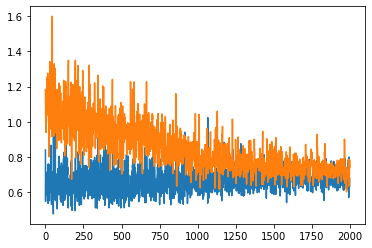

In [16]:
% matplotlib inline 
plt.figure
plt.plot(DD_2000)
plt.plot(GG_2000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

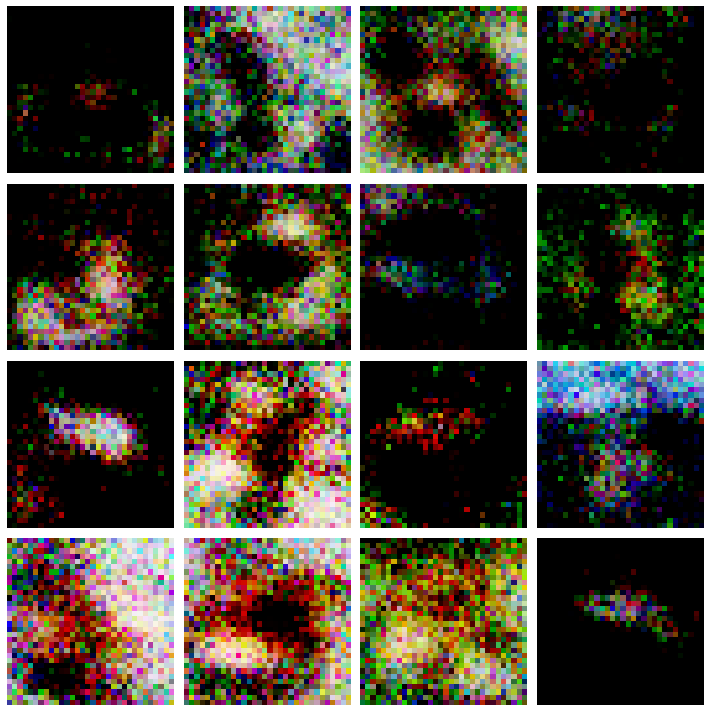

In [17]:
gan.plot_images()

In [18]:

DD_20000, GG_20000 = gan.train(X_train, epochs=20000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch: 0, [Discriminator :: d_loss: 0.681404], [ Generator :: loss: 0.740296]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 1, [Discriminator :: d_loss: 0.658190], [ Generator :: loss: 0.736089]
epoch: 2, [Discriminator :: d_loss: 0.654871], [ Generator :: loss: 0.694785]
epoch: 3, [Discriminator :: d_loss: 0.669632], [ Generator :: loss: 0.726066]
epoch: 4, [Discriminator :: d_loss: 0.676759], [ Generator :: loss: 0.719244]
epoch: 5, [Discriminator :: d_loss: 0.754606], [ Generator :: loss: 0.738882]
epoch: 6, [Discriminator :: d_loss: 0.673163], [ Generator :: loss: 0.773262]
epoch: 7, [Discriminator :: d_loss: 0.727714], [ Generator :: loss: 0.742773]
epoch: 8, [Discriminator :: d_loss: 0.651385], [ Generator :: loss: 0.721947]
epoch: 9, [Discriminator :: d_loss: 0.704357], [ Generator :: loss: 0.713601]
epoch: 10, [Discriminator :: d_loss: 0.746037], [ Generator :: loss: 0.713464]
epoch: 11, [Discriminator :: d_loss: 0.706288], [ Generator :: loss: 0.683729]
epoch: 12, [Discriminator :: d_loss: 0.728821], [ Generator :: loss: 0.686322]
epoch: 13, [Discriminator :: d_loss: 0.654674], [ Generator :

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch: 101, [Discriminator :: d_loss: 0.664220], [ Generator :: loss: 0.682653]
epoch: 102, [Discriminator :: d_loss: 0.791126], [ Generator :: loss: 0.650252]
epoch: 103, [Discriminator :: d_loss: 0.667605], [ Generator :: loss: 0.659172]
epoch: 104, [Discriminator :: d_loss: 0.722169], [ Generator :: loss: 0.671439]
epoch: 105, [Discriminator :: d_loss: 0.713498], [ Generator :: loss: 0.674953]
epoch: 106, [Discriminator :: d_loss: 0.703233], [ Generator :: loss: 0.696249]
epoch: 107, [Discriminator :: d_loss: 0.706730], [ Generator :: loss: 0.752510]
epoch: 108, [Discriminator :: d_loss: 0.655392], [ Generator :: loss: 0.796256]
epoch: 109, [Discriminator :: d_loss: 0.750584], [ Generator :: loss: 0.765162]
epoch: 110, [Discriminator :: d_loss: 0.652552], [ Generator :: loss: 0.752622]
epoch: 111, [Discriminator :: d_loss: 0.652757], [ Generator :: loss: 0.782301]
epoch: 112, [Discriminator :: d_loss: 0.648035], [ Generator :: loss: 0.768289]
epoch: 113, [Discriminator :: d_loss: 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

epoch: 201, [Discriminator :: d_loss: 0.664787], [ Generator :: loss: 0.820253]
epoch: 202, [Discriminator :: d_loss: 0.669920], [ Generator :: loss: 0.829587]
epoch: 203, [Discriminator :: d_loss: 0.667315], [ Generator :: loss: 0.806325]
epoch: 204, [Discriminator :: d_loss: 0.647178], [ Generator :: loss: 0.772856]
epoch: 205, [Discriminator :: d_loss: 0.695005], [ Generator :: loss: 0.801712]
epoch: 206, [Discriminator :: d_loss: 0.618015], [ Generator :: loss: 0.766823]
epoch: 207, [Discriminator :: d_loss: 0.648531], [ Generator :: loss: 0.790320]
epoch: 208, [Discriminator :: d_loss: 0.710068], [ Generator :: loss: 0.733301]
epoch: 209, [Discriminator :: d_loss: 0.655932], [ Generator :: loss: 0.719208]
epoch: 210, [Discriminator :: d_loss: 0.771673], [ Generator :: loss: 0.695586]
epoch: 211, [Discriminator :: d_loss: 0.672375], [ Generator :: loss: 0.723521]
epoch: 212, [Discriminator :: d_loss: 0.657352], [ Generator :: loss: 0.789699]
epoch: 213, [Discriminator :: d_loss: 0.

KeyboardInterrupt: ignored

In [ ]:
% matplotlib inline 
plt.figure
plt.plot(DD_20000)
plt.plot(GG_20000)

In [ ]:
gan.plot_images()